# Trabalho Final — Deteccao de Placas Circulares

Este notebook implementa um pipeline completo de **deteccao de placas de transito circulares** em imagens reais, utilizando exclusivamente tecnicas classicas de Processamento de Imagens.

## Estrutura do notebook

1. **Imports e configuracoes** — bibliotecas e caminhos de arquivos.
2. **Funcoes do pipeline** — organizadas por etapa:
   - Carregamento e listagem de imagens
   - Conversao de espaco de cor (RGB → HSV) e segmentacao por cor vermelha
   - Pre-processamento morfologico da mascara binaria
   - Componentes conectados para separar regioes candidatas
   - Deteccao de circulos via Transformada Circular de Hough (CHT) por componente
   - Funcoes de visualizacao e debug
   - Orquestrador do pipeline completo
3. **Execucao e resultados** — processamento das imagens com debug visual.

## Regras atendidas
- Sem OpenCV e sem PIL.
- Sem aprendizado de maquina.
- Uso apenas de `numpy`, `matplotlib`, `scikit-image` e biblioteca padrao do Python.

## 0) Imports e configuracoes gerais

A celula abaixo importa todas as bibliotecas utilizadas no projeto:

- **`csv` / `json`** — leitura e escrita de arquivos de dados (biblioteca padrao do Python).
- **`pathlib.Path`** — manipulacao de caminhos de arquivo de forma multiplataforma.
- **`time.perf_counter`** — cronometro de alta resolucao para medir o tempo de execucao do pipeline.
- **`numpy`** — operacoes numericas e manipulacao de arrays (base de toda computacao com imagens).
- **`matplotlib.pyplot`** — exibicao e salvamento de graficos e imagens.
- **`skimage.io.imread`** — leitura de imagens do disco em formato NumPy array.
- **`skimage.img_as_float`** — conversao dos valores de pixel para o intervalo `[0.0, 1.0]`.
- **`skimage.color.rgb2hsv`** — conversao do espaco de cor RGB para HSV.
- **`skimage.morphology`** — operacoes morfologicas (abertura, fechamento, erosao) e elementos estruturantes.
- **`skimage.measure`** — rotulagem de componentes conectados, propriedades de regioes e calculo de perimetro.
- **`skimage.transform`** — Transformada Circular de Hough (CHT) e deteccao de picos no espaco acumulador.
- **`skimage.draw`** — desenho de primitivas geometricas (perimetro de circulo) sobre imagens.

In [1]:
# ---------- Biblioteca padrao do Python ----------
import csv                          # Escrita de arquivos CSV
import json                         # Leitura de anotacoes opcionais em JSON
from pathlib import Path            # Manipulacao de caminhos de forma multiplataforma
from time import perf_counter       # Cronometro de alta resolucao

# ---------- Computacao numerica ----------
import numpy as np                  # Arrays n-dimensionais e operacoes vetorizadas

# ---------- Visualizacao ----------
import matplotlib.pyplot as plt     # Exibicao de imagens e graficos

# ---------- Scikit-image: leitura e conversao ----------
from skimage.io import imread                       # Leitura de imagens do disco
from skimage import img_as_float                    # Conversao para float [0, 1]
from skimage.color import rgb2hsv                   # Conversao RGB -> HSV

# ---------- Scikit-image: morfologia matematica ----------
from skimage.morphology import (
    opening,                                        # Abertura (erosao + dilatacao)
    closing,                                        # Fechamento (dilatacao + erosao)
    erosion,                                        # Erosao morfologica
    disk,                                           # Elemento estruturante circular
    remove_small_holes,                             # Preenche buracos em mascaras
)

# ---------- Scikit-image: analise de regioes ----------
from skimage.measure import (
    label,                                          # Rotulagem de componentes conectados
    regionprops,                                    # Propriedades geometricas de cada regiao
    perimeter as measure_perimeter,                 # Calculo do perimetro de uma regiao
)

# ---------- Scikit-image: Transformada de Hough ----------
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

# ---------- Configuracoes globais do matplotlib ----------
plt.rcParams["figure.figsize"] = (14, 4)   # Tamanho padrao das figuras
plt.rcParams["axes.grid"] = False           # Desabilitar grade nos graficos

### Definicao dos diretorios de trabalho

A celula seguinte define os **tres diretorios principais** do projeto:

| Variavel | Caminho | Descricao |
|---|---|---|
| `DATA_ROOT` | `data/` | Pasta onde as imagens de entrada devem estar. |
| `RESULTS_ROOT` | `results/` | Pasta raiz para todos os resultados gerados. |
| `DEBUG_DIR` | `results/debug_images/` | Subpasta para as imagens de debug salvas automaticamente. |

Os diretorios sao criados automaticamente caso ainda nao existam (via `mkdir`).

In [2]:
# Diretorio onde as imagens de entrada estao armazenadas
DATA_ROOT = Path("data")

# Diretorio raiz para todos os resultados do pipeline
RESULTS_ROOT = Path("results")

# Subdiretorio para imagens de debug (overlay com circulos detectados)
DEBUG_DIR = RESULTS_ROOT / "debug_images"

# Criar os diretorios caso nao existam
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT.resolve())
print("RESULTS_ROOT:", RESULTS_ROOT.resolve())
print("DEBUG_DIR:", DEBUG_DIR.resolve())

DATA_ROOT: /home/givaldo/pi-trabalho-final-placas-circulares/data
RESULTS_ROOT: /home/givaldo/pi-trabalho-final-placas-circulares/results
DEBUG_DIR: /home/givaldo/pi-trabalho-final-placas-circulares/results/debug_images


## 1) Funcoes do pipeline

As funcoes abaixo estao organizadas por etapa do pipeline de deteccao.

### 1.1) Carregamento e listagem de imagens

A celula seguinte define:

- **`EXTENSOES_IMAGEM_VALIDAS`** — conjunto com as extensoes de arquivo aceitas como imagens.
- **`listar_imagens()`** — varre recursivamente o diretorio de dados e retorna uma lista ordenada de caminhos para todas as imagens encontradas.
- **`carregar_imagem()`** — le um arquivo de imagem do disco e o converte para um array NumPy float64 com 3 canais (RGB), com valores normalizados entre 0.0 e 1.0. Trata automaticamente imagens em escala de cinza (replica para 3 canais) e RGBA (descarta o canal alfa).

In [61]:
# ---------------------------------------------------------------------------
# Extensoes de arquivo aceitas como imagens validas
# ---------------------------------------------------------------------------
EXTENSOES_IMAGEM_VALIDAS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}


def listar_imagens(diretorio_raiz=DATA_ROOT):
    """
    Varre recursivamente o diretorio informado e retorna uma lista ordenada
    de caminhos (Path) para todos os arquivos de imagem encontrados.

    Parametros
    ----------
    diretorio_raiz : Path ou str
        Caminho do diretorio onde buscar imagens. Padrao: DATA_ROOT.

    Retorno
    -------
    list[Path]
        Lista ordenada de caminhos das imagens encontradas.
        Retorna lista vazia se o diretorio nao existir ou nao conter imagens.
    """
    diretorio = Path(diretorio_raiz)

    if not diretorio.exists():
        print(f"Pasta '{diretorio}' nao encontrada. Coloque imagens em data/.")
        return []

    caminhos_imagens = sorted(
        caminho
        for caminho in diretorio.rglob("*")
        if caminho.is_file() and caminho.suffix.lower() in EXTENSOES_IMAGEM_VALIDAS
    )

    if not caminhos_imagens:
        print(f"Nenhuma imagem valida encontrada em {diretorio}.")

    return caminhos_imagens


def carregar_imagem(caminho_arquivo):
    """
    Le uma imagem do disco e a converte para um array NumPy float64 no
    intervalo [0.0, 1.0] com exatamente 3 canais (RGB).

    Tratamentos realizados:
    - Imagens em escala de cinza (2D) sao replicadas em 3 canais.
    - Imagens RGBA (4 canais) tem o canal alfa removido.
    - Valores de pixel sao normalizados de [0, 255] para [0.0, 1.0].

    Parametros
    ----------
    caminho_arquivo : Path ou str
        Caminho completo do arquivo de imagem.

    Retorno
    -------
    np.ndarray
        Array float64 de shape (altura, largura, 3) com valores em [0, 1].
    """
    imagem_bruta = imread(caminho_arquivo)

    # Imagem em escala de cinza (2D): replicar em 3 canais para simular RGB
    if imagem_bruta.ndim == 2:
        imagem_bruta = np.stack(
            [imagem_bruta, imagem_bruta, imagem_bruta], axis=-1
        )
    # Imagem RGBA (4 canais): descartar o canal alfa (transparencia)
    elif imagem_bruta.ndim == 3 and imagem_bruta.shape[2] == 4:
        imagem_bruta = imagem_bruta[..., :3]

    return img_as_float(imagem_bruta)

### 1.2) Conversao HSV, segmentacao por cor vermelha e pre-processamento morfologico

A celula seguinte define tres funcoes que compõem as primeiras etapas de processamento:

**`converter_para_hsv()`** — Converte a imagem do espaco de cor RGB para **HSV** (Hue, Saturation, Value). No HSV a informacao de **cor** (canal H) fica separada da **iluminacao** (canal V), o que torna a segmentacao por cor muito mais robusta do que no RGB.

**`segmentar_vermelho_hsv()`** — Gera uma mascara binaria dos pixels vermelhos. O vermelho no HSV e especial porque ocupa **duas faixas** do canal Hue (matiz e circular: 0° = 360°):
- Faixa 1: Hue entre ~0° e ~25° (vermelho puro, proximo de 0)
- Faixa 2: Hue entre ~335° e ~360° (vermelho puro, proximo de 1)

Alem do Hue, exigimos **saturacao minima** (evitar cinzas) e **valor minimo** (evitar pixels muito escuros).

**`preprocessar_mascara()`** — Limpa a mascara binaria com **duas operacoes morfologicas**:
1. **Abertura** (opening = erosao + dilatacao): remove ruidos pequenos e pontos isolados.
2. **Fechamento** (closing = dilatacao + erosao): preenche lacunas e conecta regioes proximas.

O **elemento estruturante** usado e um **disco** (circular), adequado para formas arredondadas.

In [62]:
def converter_para_hsv(imagem_rgb):
    """
    Converte uma imagem do espaco de cor RGB para o espaco HSV.

    No espaco HSV:
    - H (Hue / Matiz): indica a cor dominante, valor em [0, 1] mapeando [0, 360].
    - S (Saturation / Saturacao): intensidade da cor, 0 = cinza, 1 = cor pura.
    - V (Value / Valor): brilho do pixel, 0 = preto, 1 = brilho maximo.

    A segmentacao por cor no espaco HSV e mais robusta que no RGB porque
    separa a informacao de cor (H) da iluminacao (V).

    Parametros
    ----------
    imagem_rgb : np.ndarray
        Imagem RGB float64 com shape (altura, largura, 3).

    Retorno
    -------
    np.ndarray
        Imagem HSV float64 com shape (altura, largura, 3).
    """
    return rgb2hsv(imagem_rgb)


def segmentar_vermelho_hsv(
    imagem_hsv,
    hue_minimo_faixa1=0.00,
    hue_maximo_faixa1=0.07,
    hue_minimo_faixa2=0.93,
    hue_maximo_faixa2=1.00,
    saturacao_minima=0.35,
    valor_minimo=0.20,
):
    """
    Gera uma mascara binaria dos pixels vermelhos de uma imagem HSV.

    O vermelho no espaco HSV ocupa DUAS faixas de Hue (matiz circular):
      - Faixa 1: hue proximo de 0  (vermelho puro, ~0 a ~25 graus)
      - Faixa 2: hue proximo de 1  (vermelho puro, ~335 a 360 graus)

    Alem do Hue, exigimos saturacao e valor minimos para evitar
    selecionar pixels acinzentados ou muito escuros.

    Parametros
    ----------
    imagem_hsv : np.ndarray
        Imagem no espaco HSV com shape (altura, largura, 3), valores em [0, 1].
    hue_minimo_faixa1 : float
        Limite inferior da primeira faixa de Hue (padrao 0.00).
    hue_maximo_faixa1 : float
        Limite superior da primeira faixa de Hue (padrao 0.07).
    hue_minimo_faixa2 : float
        Limite inferior da segunda faixa de Hue (padrao 0.93).
    hue_maximo_faixa2 : float
        Limite superior da segunda faixa de Hue (padrao 1.00).
    saturacao_minima : float
        Saturacao minima para considerar o pixel como colorido (padrao 0.35).
    valor_minimo : float
        Valor (brilho) minimo para excluir pixels muito escuros (padrao 0.20).

    Retorno
    -------
    np.ndarray (bool)
        Mascara binaria onde True = pixel vermelho detectado.
    """
    canal_hue = imagem_hsv[..., 0]
    canal_saturacao = imagem_hsv[..., 1]
    canal_valor = imagem_hsv[..., 2]

    # O vermelho "envolve" o circulo de matiz (0 = 360), entao usa duas faixas
    mascara_hue_vermelho = (
        ((canal_hue >= hue_minimo_faixa1) & (canal_hue <= hue_maximo_faixa1))
        | ((canal_hue >= hue_minimo_faixa2) & (canal_hue <= hue_maximo_faixa2))
    )

    # Combinar matiz + saturacao + valor para mascara final
    mascara_vermelha = (
        mascara_hue_vermelho
        & (canal_saturacao >= saturacao_minima)
        & (canal_valor >= valor_minimo)
    )

    return mascara_vermelha


def preprocessar_mascara(mascara_binaria, raio_abertura=1, raio_fechamento=5):
    """
    Aplica operacoes morfologicas para limpar a mascara de segmentacao.

    Etapa 1 - Abertura (opening = erosao + dilatacao):
      Remove pequenos ruidos e pontos isolados (falsos positivos).
      Elemento estruturante: disco com raio `raio_abertura`.

    Etapa 2 - Fechamento (closing = dilatacao + erosao):
      Preenche pequenas lacunas e conecta regioes proximas.
      Elemento estruturante: disco com raio `raio_fechamento`.

    Parametros
    ----------
    mascara_binaria : np.ndarray (bool)
        Mascara de segmentacao bruta (saida de segmentar_vermelho_hsv).
    raio_abertura : int
        Raio do disco para a operacao de abertura (padrao 1).
    raio_fechamento : int
        Raio do disco para a operacao de fechamento (padrao 5).

    Retorno
    -------
    np.ndarray (bool)
        Mascara limpa apos as operacoes morfologicas.
    """
    mascara_aberta = opening(mascara_binaria, disk(raio_abertura))
    mascara_fechada = closing(mascara_aberta, disk(raio_fechamento))
    return mascara_fechada

### 1.3) Transformada Circular de Hough (CHT) e componentes conectados

A celula seguinte implementa as duas funcoes centrais do pipeline:

**`detectar_circulos_hough()`** — Aplica a **Transformada Circular de Hough (CHT)** para encontrar circulos em uma mascara binaria. O funcionamento da CHT:
1. Para cada pixel de **borda** (contorno do componente), vota em todos os possiveis centros de circulo para cada raio candidato.
2. O **espaco acumulador 3D** (centro_x, centro_y, raio) acumula esses votos.
3. Os **picos** no acumulador indicam os circulos com maior evidencia.

Antes da CHT, extraimos as bordas do componente pela **diferenca entre a mascara original e sua erosao** (`mascara XOR erosao`), produzindo apenas os pixels de contorno.

**`separar_componentes_conectados()`** — Identifica regioes isoladas (componentes conectados) na mascara binaria usando **rotulagem por conectividade-8**. Cada componente recebe um identificador unico, e seus atributos (area, bounding box, mascara recortada) sao extraidos via `regionprops`. Componentes com area menor que o limiar minimo sao descartados como ruido.

In [63]:
def detectar_circulos_hough(
    mascara_binaria,
    raio_minimo=8,
    raio_maximo=None,
    passo_raio=2,
    numero_picos=3,
    retornar_debug=False,
):
    """
    Aplica a Transformada Circular de Hough (CHT) para detectar circulos
    em uma mascara binaria.

    A CHT funciona da seguinte forma:
    1. Para cada pixel de borda, vota em todos os possiveis centros de
       circulo para cada raio candidato no espaco acumulador.
    2. O espaco acumulador 3D (centro_x, centro_y, raio) acumula votos.
    3. Os picos no acumulador indicam os circulos mais provaveis.

    Antes de aplicar a CHT, extraimos as bordas da mascara por diferenca
    entre a mascara original e sua erosao (borda = mascara XOR erosao).

    Parametros
    ----------
    mascara_binaria : np.ndarray
        Mascara binaria do componente (True = pixel de interesse).
    raio_minimo : int
        Menor raio a ser testado pela CHT (padrao 8).
    raio_maximo : int ou None
        Maior raio a ser testado. Se None, calcula como 35% da menor dimensao.
    passo_raio : int
        Incremento entre raios consecutivos testados (padrao 2).
    numero_picos : int
        Quantidade maxima de circulos candidatos a retornar (padrao 3).
    retornar_debug : bool
        Se True, retorna tupla (circulos, debug_dict) com dados intermediarios
        para visualizacao do espaco acumulador (padrao False).

    Retorno
    -------
    list[dict]  (se retornar_debug=False)
        Lista de dicionarios com center_x, center_y, radius, score.
    tuple(list[dict], dict)  (se retornar_debug=True)
        (circulos, debug) onde debug contem:
        - "mapa_bordas": mascara de bordas usada como entrada da CHT
        - "acumulador_max": projecao maxima do espaco acumulador 3D (2D heatmap)
        - "raios_candidatos": array de raios testados
    """
    if mascara_binaria.dtype != bool:
        mascara_binaria = mascara_binaria.astype(bool)

    altura_mascara, largura_mascara = mascara_binaria.shape
    dimensao_minima = min(altura_mascara, largura_mascara)

    # Calculo automatico do raio maximo se nao informado
    if raio_maximo is None:
        raio_maximo = int(dimensao_minima * 0.35)

    # Garantir limites razoaveis para os raios
    raio_minimo = max(4, int(raio_minimo))
    raio_maximo = min(int(raio_maximo), max(5, dimensao_minima // 2 + 2))

    # Debug vazio para retornar quando nao ha circulos
    debug_vazio = {
        "mapa_bordas": np.zeros_like(mascara_binaria, dtype=bool),
        "acumulador_max": np.zeros((altura_mascara, largura_mascara), dtype=float),
        "raios_candidatos": np.array([], dtype=np.int32),
    }

    if raio_minimo > raio_maximo:
        return ([], debug_vazio) if retornar_debug else []

    # Gerar o vetor de raios candidatos para a CHT
    raios_candidatos = np.arange(
        raio_minimo,
        raio_maximo + 1,
        max(1, int(passo_raio)),
        dtype=np.int32,
    )
    if raios_candidatos.size == 0:
        return ([], debug_vazio) if retornar_debug else []

    # Extrair bordas: diferenca simetrica entre mascara e sua erosao
    # Isso produz apenas os pixels de contorno do componente
    mapa_bordas = mascara_binaria ^ erosion(mascara_binaria, disk(1))
    if not mapa_bordas.any():
        mapa_bordas = mascara_binaria  # fallback se erosao eliminar tudo

    # Aplicar a Transformada Circular de Hough
    espaco_hough = hough_circle(mapa_bordas.astype(np.uint8), raios_candidatos)

    # Projecao maxima do acumulador 3D para visualizacao 2D
    # Cada pixel mostra o valor maximo de voto dentre todos os raios testados
    acumulador_max = espaco_hough.max(axis=0).astype(float)

    # Encontrar os picos (circulos mais votados) no espaco acumulador
    acumuladores, centros_coluna, centros_linha, raios_detectados = hough_circle_peaks(
        espaco_hough,
        raios_candidatos,
        total_num_peaks=int(numero_picos),
    )

    # Montar lista de circulos detectados
    circulos_detectados = []
    for score, col_centro, lin_centro, raio in zip(
        acumuladores, centros_coluna, centros_linha, raios_detectados
    ):
        circulos_detectados.append(
            {
                "center_x": int(col_centro),
                "center_y": int(lin_centro),
                "radius": int(raio),
                "score": float(score),
            }
        )

    if retornar_debug:
        debug_info = {
            "mapa_bordas": mapa_bordas,
            "acumulador_max": acumulador_max,
            "raios_candidatos": raios_candidatos,
        }
        return circulos_detectados, debug_info

    return circulos_detectados


def separar_componentes_conectados(mascara_binaria, area_minima=150):
    """
    Identifica e separa os componentes conectados (regioes isoladas) de
    uma mascara binaria, filtrando por area minima.

    Cada componente e uma regiao contigua de pixels True na mascara.
    O algoritmo de rotulagem (label) atribui um ID unico a cada componente,
    e regionprops calcula propriedades como area e bounding box.

    Parametros
    ----------
    mascara_binaria : np.ndarray
        Mascara binaria limpa (pos-morfologia).
    area_minima : int
        Numero minimo de pixels para considerar um componente valido.
        Componentes menores sao descartados como ruido (padrao 150).

    Retorno
    -------
    list[dict]
        Lista de componentes (maior area primeiro), cada um com:
        - "label": identificador numerico do componente
        - "bbox": (linha_min, coluna_min, linha_max, coluna_max)
        - "mask": mascara binaria recortada do componente
        - "area": numero total de pixels do componente
    """
    mascara_rotulada = label(mascara_binaria.astype(np.uint8), connectivity=2)
    lista_componentes = []

    for regiao in regionprops(mascara_rotulada):
        if int(regiao.area) < int(area_minima):
            continue

        linha_min, coluna_min, linha_max, coluna_max = regiao.bbox
        mascara_componente = (
            mascara_rotulada[linha_min:linha_max, coluna_min:coluna_max] == regiao.label
        )

        lista_componentes.append(
            {
                "label": int(regiao.label),
                "bbox": (int(linha_min), int(coluna_min), int(linha_max), int(coluna_max)),
                "mask": mascara_componente,
                "area": int(regiao.area),
            }
        )

    # Ordenar por area decrescente (maiores componentes primeiro)
    lista_componentes.sort(key=lambda componente: componente["area"], reverse=True)
    return lista_componentes


def calcular_metricas_circulo_borda(mascara_componente, circulo, tolerancia=3.0):
    """
    Calcula metricas geometricas simples entre um componente e um circulo.

    Metricas retornadas:
    - cobertura_borda: proximos / total de pixels de borda do componente.
    - cobertura_perimetro: proximos / (2 * pi * raio do circulo).
      Esta metrica e mais robusta para componentes em formato de anel
      (borda interna + externa), evitando penalizacao excessiva.
    - radial_cv: coeficiente de variacao das distancias da borda ao centro
      (std(distancias) / media(distancias)). Quanto menor, mais circular.
    """
    mapa_bordas = mascara_componente ^ erosion(mascara_componente, disk(1))
    linhas_borda, colunas_borda = np.nonzero(mapa_bordas)
    total_borda = len(linhas_borda)

    if total_borda == 0:
        return {
            "cobertura_borda": 0.0,
            "cobertura_perimetro": 0.0,
            "radial_cv": 1.0,
            "pixels_proximos": 0,
            "total_borda": 0,
        }

    cx = float(circulo["center_x"])
    cy = float(circulo["center_y"])
    raio = max(float(circulo["radius"]), 1.0)

    distancias_ao_centro = np.sqrt(
        (colunas_borda.astype(float) - cx) ** 2
        + (linhas_borda.astype(float) - cy) ** 2
    )
    desvios_radiais = np.abs(distancias_ao_centro - raio)
    proximos = desvios_radiais <= float(tolerancia)
    pixels_proximos = int(proximos.sum())

    cobertura_borda = float(pixels_proximos) / float(total_borda)
    perimetro_esperado = max(1.0, 2.0 * np.pi * raio)
    cobertura_perimetro = min(1.0, float(pixels_proximos) / perimetro_esperado)

    media_distancias = float(distancias_ao_centro.mean())
    if media_distancias <= 1e-6:
        radial_cv = 1.0
    else:
        radial_cv = float(distancias_ao_centro.std() / media_distancias)

    return {
        "cobertura_borda": cobertura_borda,
        "cobertura_perimetro": cobertura_perimetro,
        "radial_cv": radial_cv,
        "pixels_proximos": pixels_proximos,
        "total_borda": int(total_borda),
    }


def refinar_circulo_por_borda(
    mascara_componente,
    circulo_inicial,
    tolerancia=3.0,
    janela_centro=3,
    janela_raio=3,
):
    """
    Refina localmente o melhor circulo da CHT por busca discreta.

    O objetivo e corrigir pequenos desalinhamentos de centro/raio sem
    adicionar tecnicas complexas: testa perturbacoes locais e escolhe o
    circulo com maior cobertura_perimetro; em empate, menor radial_cv.
    """
    if circulo_inicial is None:
        return None, {
            "cobertura_borda": 0.0,
            "cobertura_perimetro": 0.0,
            "radial_cv": 1.0,
            "pixels_proximos": 0,
            "total_borda": 0,
        }

    melhor_circulo = {
        "center_x": int(circulo_inicial["center_x"]),
        "center_y": int(circulo_inicial["center_y"]),
        "radius": int(circulo_inicial["radius"]),
        "score": float(circulo_inicial.get("score", 0.0)),
    }
    melhor_metrica = calcular_metricas_circulo_borda(
        mascara_componente, melhor_circulo, tolerancia=tolerancia
    )
    melhor_criterio = (
        float(melhor_metrica["cobertura_perimetro"]),
        -float(melhor_metrica["radial_cv"]),
    )

    cx0 = int(circulo_inicial["center_x"])
    cy0 = int(circulo_inicial["center_y"])
    r0 = int(circulo_inicial["radius"])

    for dy in range(-int(janela_centro), int(janela_centro) + 1):
        for dx in range(-int(janela_centro), int(janela_centro) + 1):
            for dr in range(-int(janela_raio), int(janela_raio) + 1):
                raio_candidato = max(3, int(r0 + dr))
                circulo_candidato = {
                    "center_x": int(cx0 + dx),
                    "center_y": int(cy0 + dy),
                    "radius": int(raio_candidato),
                    "score": float(circulo_inicial.get("score", 0.0)),
                }
                metrica_candidata = calcular_metricas_circulo_borda(
                    mascara_componente, circulo_candidato, tolerancia=tolerancia
                )
                criterio_candidato = (
                    float(metrica_candidata["cobertura_perimetro"]),
                    -float(metrica_candidata["radial_cv"]),
                )
                if criterio_candidato > melhor_criterio:
                    melhor_criterio = criterio_candidato
                    melhor_circulo = circulo_candidato
                    melhor_metrica = metrica_candidata

    return melhor_circulo, melhor_metrica


def calcular_cobertura_borda(mascara_componente, circulo, tolerancia=3.0):
    """
    Retorna cobertura de borda normalizada pelo perimetro do circulo.
    """
    metricas = calcular_metricas_circulo_borda(
        mascara_componente, circulo, tolerancia=tolerancia
    )
    return float(metricas["cobertura_perimetro"])


### 1.4) Funcoes de visualizacao e debug

A celula seguinte define tres funcoes para **visualizar os resultados** do pipeline:

**`desenhar_circulo()`** — Desenha o perimetro de um circulo e uma marca no centro sobre a imagem original. Usa `skimage.draw.circle_perimeter` para calcular os pixels do contorno.

**`desenhar_todos_circulos()`** — Desenha **todos** os circulos detectados pela CHT sobre a imagem em verde.

**`exibir_debug_imagem()`** — Monta um painel completo de debug com **6 subplots** (2 linhas × 3 colunas):

| Posicao | Conteudo |
|---|---|
| (0,0) | Imagem original |
| (0,1) | Mascara vermelha bruta (antes da morfologia) |
| (0,2) | Mascara vermelha limpa (apos morfologia) |
| (1,0) | Componentes conectados com bounding box amarelo |
| (1,1) | Todos os circulos detectados pela CHT |
| (1,2) | Resultado final (melhor circulo por score) |

In [64]:
def desenhar_circulo(imagem, circulo, cor=(0.0, 1.0, 0.0)):
    """
    Desenha o perimetro de um circulo e uma marca de centro sobre a imagem.

    Parametros
    ----------
    imagem : np.ndarray
        Imagem RGB float64 com shape (altura, largura, 3).
    circulo : dict ou None
        Circulo com "center_x", "center_y", "radius". Se None, retorna copia.
    cor : tuple
        Cor RGB normalizada para o desenho (padrao verde: (0, 1, 0)).

    Retorno
    -------
    np.ndarray
        Copia da imagem com o circulo desenhado.
    """
    imagem_saida = imagem.copy()

    if circulo is None:
        return imagem_saida

    # Calcular os pixels do perimetro do circulo
    indices_linha, indices_coluna = circle_perimeter(
        int(circulo["center_y"]),
        int(circulo["center_x"]),
        int(circulo["radius"]),
        shape=imagem_saida.shape[:2],
    )
    imagem_saida[indices_linha, indices_coluna] = np.asarray(cor)

    # Desenhar marca no centro (quadrado 5x5 pixels)
    centro_linha = int(circulo["center_y"])
    centro_coluna = int(circulo["center_x"])
    marca_linha_inicio = max(0, centro_linha - 2)
    marca_linha_fim = min(imagem_saida.shape[0], centro_linha + 3)
    marca_coluna_inicio = max(0, centro_coluna - 2)
    marca_coluna_fim = min(imagem_saida.shape[1], centro_coluna + 3)
    imagem_saida[
        marca_linha_inicio:marca_linha_fim,
        marca_coluna_inicio:marca_coluna_fim,
    ] = np.asarray(cor)

    return imagem_saida


def desenhar_todos_circulos(imagem, lista_circulos):
    """
    Desenha todos os circulos detectados sobre a imagem em verde.

    Parametros
    ----------
    imagem : np.ndarray
        Imagem RGB float64.
    lista_circulos : list[dict]
        Lista de circulos com coordenadas center_x, center_y, radius.

    Retorno
    -------
    np.ndarray
        Copia da imagem com todos os circulos desenhados.
    """
    imagem_saida = imagem.copy()

    for circulo in lista_circulos:
        try:
            indices_linha, indices_coluna = circle_perimeter(
                int(circulo["center_y"]),
                int(circulo["center_x"]),
                int(circulo["radius"]),
                shape=imagem_saida.shape[:2],
            )
            imagem_saida[indices_linha, indices_coluna] = np.asarray([0.0, 1.0, 0.0])
        except ValueError:
            pass

    return imagem_saida


def exibir_debug_imagem(resultado_pipeline):
    """
    Exibe um painel de debug visual completo para uma imagem processada.

    Layout (2 linhas x 3 colunas):
      Linha 1: Original | Mascara bruta | Mascara limpa
      Linha 2: Componentes com bbox | Todos os circulos CHT | Resultado final

    Parametros
    ----------
    resultado_pipeline : dict
        Dicionario retornado por executar_pipeline_imagem().
    """
    dados_debug = resultado_pipeline["debug"]
    melhor_circulo = resultado_pipeline["best_circle"]
    nome_arquivo = Path(resultado_pipeline["image_path"]).name

    figura, eixos = plt.subplots(2, 3, figsize=(18, 11))
    figura.suptitle(f"Debug: {nome_arquivo}", fontsize=14)

    # --- Linha 1: Original | Mascara bruta | Mascara limpa ---
    eixos[0, 0].imshow(dados_debug["original"])
    eixos[0, 0].set_title("Original")
    eixos[0, 0].axis("off")

    eixos[0, 1].imshow(dados_debug["mask_raw"], cmap="gray")
    eixos[0, 1].set_title("Mascara vermelha (bruta)")
    eixos[0, 1].axis("off")

    eixos[0, 2].imshow(dados_debug["mask_clean"], cmap="gray")
    eixos[0, 2].set_title("Mascara vermelha (limpa)")
    eixos[0, 2].axis("off")

    # --- Linha 2: Componentes | Circulos CHT | Resultado ---
    visualizacao_componentes = dados_debug["original"].copy()
    altura_imagem, largura_imagem = visualizacao_componentes.shape[:2]

    for componente in dados_debug["components"]:
        linha_min, coluna_min, linha_max, coluna_max = componente["bbox"]
        linha_max_segura = min(linha_max, altura_imagem - 1)
        coluna_max_segura = min(coluna_max, largura_imagem - 1)
        # Desenhar retangulo amarelo ao redor do componente
        visualizacao_componentes[linha_min:linha_max_segura, coluna_min, :] = [1, 1, 0]
        visualizacao_componentes[linha_min:linha_max_segura, coluna_max_segura, :] = [1, 1, 0]
        visualizacao_componentes[linha_min, coluna_min:coluna_max_segura, :] = [1, 1, 0]
        visualizacao_componentes[linha_max_segura, coluna_min:coluna_max_segura, :] = [1, 1, 0]

    eixos[1, 0].imshow(visualizacao_componentes)
    eixos[1, 0].set_title(f"Componentes ({resultado_pipeline['n_components']})")
    eixos[1, 0].axis("off")

    eixos[1, 1].imshow(dados_debug["debug_overlay"])
    total_circulos = len(dados_debug["all_circles"])
    eixos[1, 1].set_title(f"Circulos CHT detectados: {total_circulos}")
    eixos[1, 1].axis("off")

    eixos[1, 2].imshow(dados_debug["overlay"])
    if melhor_circulo is None:
        eixos[1, 2].set_title("Resultado: NENHUM circulo detectado", color="red")
    else:
        eixos[1, 2].set_title(
            f"DETECTADO  r={melhor_circulo['radius']}  "
            f"score={melhor_circulo['score']:.1f}"
        )
    eixos[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

### 1.4b) Visualizacao do espaco acumulador da CHT

A funcao abaixo exibe, para cada componente de uma imagem processada, um painel com **4 subplots** que detalham o funcionamento interno da Transformada Circular de Hough:

| Posicao | Conteudo | O que mostra |
|---|---|---|
| (0) | **Mascara do componente** | O blob isolado apos segmentacao e morfologia — entrada do processamento. |
| (1) | **Mapa de bordas** | Contorno extraido por `mascara XOR erosao(mascara)` — **entrada real da CHT**. Somente estes pixels votam no acumulador. |
| (2) | **Espaco acumulador (heatmap)** | Projecao maxima do acumulador 3D sobre todos os raios testados. Pixels mais claros = mais votos = maior evidencia de centro de circulo. Os picos detectados sao marcados com `×`. |
| (3) | **Circulos detectados** | Todos os circulos candidatos retornados pela CHT. O melhor (maior score) aparece em verde, demais em amarelo. |

In [65]:
def exibir_debug_cht_componentes(resultado_pipeline):
    """
    Exibe o debug detalhado da CHT para cada componente conectado de uma
    imagem processada. Para cada componente, mostra 4 paineis:

    1. Mascara do componente (blob isolado)
    2. Mapa de bordas (entrada real da CHT — somente estes pixels votam)
    3. Espaco acumulador como heatmap (votos por posicao de centro)
    4. Circulos detectados pela CHT + cobertura de borda

    Parametros
    ----------
    resultado_pipeline : dict
        Dicionario retornado por executar_pipeline_imagem().
        Deve conter a chave "debug" -> "cht_por_componente" com os dados
        intermediarios da CHT.
    """
    nome_arquivo = Path(resultado_pipeline["image_path"]).name
    dados_cht = resultado_pipeline["debug"].get("cht_por_componente", [])

    if not dados_cht:
        print(f"{nome_arquivo}: nenhum componente com dados CHT para exibir.")
        return

    for idx_comp, dados_comp in enumerate(dados_cht):
        mascara = dados_comp["mascara"]
        bordas = dados_comp["mapa_bordas"]
        acumulador = dados_comp["acumulador_max"]
        circulos_brutos = dados_comp["circulos_brutos"]
        bbox = dados_comp["bbox"]
        cobertura = dados_comp.get(
            "cobertura_perimetro",
            dados_comp.get("cobertura", 0.0),
        )
        radial_cv = dados_comp.get("radial_cv", 0.0)
        rejeitado = dados_comp.get("rejeitado", False)

        # Montar titulo com status das metricas de validacao
        status_cobertura = f"cov={cobertura:.2f}  cv={radial_cv:.3f}"
        if rejeitado:
            status_cobertura += " \u2717 REJEITADO"
        else:
            status_cobertura += " \u2713 APROVADO"

        figura, eixos = plt.subplots(1, 4, figsize=(20, 4.5))
        figura.suptitle(
            f"{nome_arquivo} \u2014 Componente {idx_comp + 1} "
            f"(bbox: lin {bbox[0]}:{bbox[2]}, col {bbox[1]}:{bbox[3]})  "
            f"[{status_cobertura}]",
            fontsize=12,
            color="red" if rejeitado else "green",
        )

        # --- (0) Mascara do componente ---
        eixos[0].imshow(mascara, cmap="gray")
        eixos[0].set_title(f"Mascara componente\n({int(mascara.sum())} px)")
        eixos[0].axis("off")

        # --- (1) Mapa de bordas (entrada da CHT) ---
        eixos[1].imshow(bordas, cmap="gray")
        eixos[1].set_title(f"Bordas (entrada CHT)\n({int(bordas.sum())} px)")
        eixos[1].axis("off")

        # --- (2) Acumulador como heatmap ---
        if acumulador.max() > 0:
            acumulador_normalizado = acumulador / acumulador.max()
        else:
            acumulador_normalizado = acumulador

        mapa_calor = eixos[2].imshow(
            acumulador_normalizado, cmap="hot", interpolation="nearest"
        )

        # Marcar picos (centros detectados) no acumulador com x ciano
        for circ in circulos_brutos:
            eixos[2].plot(
                circ["center_x"], circ["center_y"],
                marker="x", color="cyan", markersize=10, markeredgewidth=2,
            )
            eixos[2].annotate(
                f"r={circ['radius']}",
                (circ["center_x"], circ["center_y"]),
                textcoords="offset points", xytext=(5, -10),
                fontsize=8, color="cyan",
            )
        eixos[2].set_title(
            f"Acumulador CHT (max proj)\n{len(circulos_brutos)} pico(s)"
        )
        eixos[2].axis("off")
        figura.colorbar(mapa_calor, ax=eixos[2], fraction=0.046, pad=0.04)

        # --- (3) Circulos detectados pela CHT + validacao ---
        visualizacao_circulos = np.stack(
            [mascara.astype(float)] * 3, axis=-1
        ) * 0.4

        # Circulos brutos em amarelo
        melhor_local = dados_comp.get("melhor_circulo_refinado")
        if melhor_local is None and circulos_brutos:
            melhor_local = max(circulos_brutos, key=lambda c: c["score"])

        for circ in circulos_brutos:
            cor_circ = [1.0, 1.0, 0.0]
            try:
                indices_linha, indices_coluna = circle_perimeter(
                    int(circ["center_y"]), int(circ["center_x"]),
                    int(circ["radius"]), shape=mascara.shape,
                )
                visualizacao_circulos[indices_linha, indices_coluna] = cor_circ
            except ValueError:
                pass
            # Marca do centro (quadrado 5x5)
            centro_lin = int(circ["center_y"])
            centro_col = int(circ["center_x"])
            lin_ini = max(0, centro_lin - 2)
            lin_fim = min(mascara.shape[0], centro_lin + 3)
            col_ini = max(0, centro_col - 2)
            col_fim = min(mascara.shape[1], centro_col + 3)
            visualizacao_circulos[lin_ini:lin_fim, col_ini:col_fim] = cor_circ

        # Melhor circulo refinado em verde (aprovado) ou vermelho (rejeitado)
        if melhor_local is not None:
            cor_melhor = [1.0, 0.0, 0.0] if rejeitado else [0.0, 1.0, 0.0]
            try:
                indices_linha, indices_coluna = circle_perimeter(
                    int(melhor_local["center_y"]), int(melhor_local["center_x"]),
                    int(melhor_local["radius"]), shape=mascara.shape,
                )
                visualizacao_circulos[indices_linha, indices_coluna] = cor_melhor
            except ValueError:
                pass
            centro_lin = int(melhor_local["center_y"])
            centro_col = int(melhor_local["center_x"])
            lin_ini = max(0, centro_lin - 2)
            lin_fim = min(mascara.shape[0], centro_lin + 3)
            col_ini = max(0, centro_col - 2)
            col_fim = min(mascara.shape[1], centro_col + 3)
            visualizacao_circulos[lin_ini:lin_fim, col_ini:col_fim] = cor_melhor

        eixos[3].imshow(visualizacao_circulos)
        if melhor_local is not None:
            titulo_circ = (
                f"r={melhor_local['radius']}  "
                f"score={melhor_local['score']:.1f}  "
                f"cov={cobertura:.2f}  cv={radial_cv:.3f}"
            )
            if rejeitado:
                eixos[3].set_title(
                    f"REJEITADO (cov/cv)\n{titulo_circ}",
                    color="red",
                )
            else:
                eixos[3].set_title(
                    f"Circulos CHT (verde=melhor)\n{titulo_circ}",
                )
        else:
            eixos[3].set_title("Nenhum circulo detectado")
        eixos[3].axis("off")

        plt.tight_layout()
        plt.show()


### 1.5) Parametros padrao e pipeline completo (orquestrador)

A celula seguinte define:

**`PARAMETROS_PADRAO`** — Dicionario com todos os thresholds e configuracoes do pipeline, organizados por etapa:
- `"hsv"`: faixas de Hue, saturacao e valor minimos para segmentacao vermelha.
- `"morph"`: raios dos elementos estruturantes para abertura e fechamento.
- `"component"`: area minima absoluta e relativa para filtrar componentes.
- `"circle"`: limites de raio e parametros da CHT.

**`executar_pipeline_imagem()`** — Funcao **orquestradora** que executa o pipeline completo em uma unica imagem, encadeando todas as etapas:

1. **Carregar** a imagem e converter para HSV.
2. **Segmentar** os pixels vermelhos e **limpar** com morfologia.
3. **Separar** os componentes conectados e filtrar por area.
4. Para cada componente: aplicar **CHT** e selecionar o circulo com **maior score**.
5. **Selecionar** o melhor circulo global (maior score entre todos os componentes).
6. **Gerar** imagens de overlay para debug.

Retorna um dicionario completo com resultado e dados de debug.

In [66]:
# ---------------------------------------------------------------------------
# Parametros padrao do pipeline — podem ser sobrescritos na chamada
# ---------------------------------------------------------------------------
PARAMETROS_PADRAO = {
    "hsv": {
        "hue_minimo_faixa1": 0.00,
        "hue_maximo_faixa1": 0.07,
        "hue_minimo_faixa2": 0.93,
        "hue_maximo_faixa2": 1.00,
        "saturacao_minima": 0.35,
        "valor_minimo": 0.20,
    },
    "morph": {
        "raio_abertura": 1,
        "raio_fechamento": 5,
    },
    "component": {
        "area_minima": 150,
        "area_relativa_minima": 0.12,
    },
    "circle": {
        "raio_minimo": None,
        "raio_maximo": None,
        "passo_raio": 2,
        "numero_picos": 3,
    },
    "validation": {
        "cobertura_borda_minima": 0.40,
        "tolerancia_borda": 3.0,
        "radial_cv_maximo": 0.20,
        "janela_refino_centro": 3,
        "janela_refino_raio": 3,
    },
}


def executar_pipeline_imagem(caminho_imagem, parametros_customizados=None):
    """
    Executa o pipeline completo de deteccao de placas circulares em uma
    unica imagem, encadeando todas as etapas.

    Etapas:
    1. Carregar a imagem e converter para HSV.
    2. Segmentar pixels vermelhos e limpar com morfologia.
    3. Separar componentes conectados e filtrar por area.
    4. Para cada componente: aplicar CHT, refinar levemente o melhor
       circulo e validar por metricas geometricas simples.
    5. Selecionar o melhor circulo global (maior score entre os aprovados).
    6. Gerar imagens de overlay para debug.

    Parametros
    ----------
    caminho_imagem : Path ou str
        Caminho do arquivo de imagem a processar.
    parametros_customizados : dict ou None
        Dicionario opcional para sobrescrever parametros padrao.
        Estrutura: {"hsv": {...}, "morph": {...}, ...}

    Retorno
    -------
    dict
        Dicionario com:
        - "image_path": caminho da imagem processada
        - "n_components": numero de componentes analisados
        - "n_circles_raw": circulos brutos detectados pela CHT
        - "best_circle": melhor circulo (dict) ou None
        - "best_circle_score": score do melhor circulo ou None
        - "detected": True se algum circulo foi encontrado
        - "execution_ms": tempo total de execucao em milissegundos
        - "debug": sub-dicionario com imagens e dados intermediarios
    """
    if parametros_customizados is None:
        parametros_customizados = {}

    # Mesclar parametros customizados com os padroes
    parametros_hsv = {
        **PARAMETROS_PADRAO["hsv"],
        **parametros_customizados.get("hsv", {}),
    }
    parametros_morfologia = {
        **PARAMETROS_PADRAO["morph"],
        **parametros_customizados.get("morph", {}),
    }
    parametros_componente = {
        **PARAMETROS_PADRAO["component"],
        **parametros_customizados.get("component", {}),
    }
    parametros_circulo = {
        **PARAMETROS_PADRAO["circle"],
        **parametros_customizados.get("circle", {}),
    }
    parametros_validacao = {
        **PARAMETROS_PADRAO["validation"],
        **parametros_customizados.get("validation", {}),
    }

    tempo_inicio = perf_counter()

    # ---- Etapa 1: Carregar imagem e converter para HSV ----
    imagem_rgb = carregar_imagem(caminho_imagem)
    imagem_hsv = converter_para_hsv(imagem_rgb)

    # ---- Etapa 2: Segmentar vermelho e limpar mascara ----
    mascara_bruta = segmentar_vermelho_hsv(imagem_hsv, **parametros_hsv)
    mascara_limpa = preprocessar_mascara(mascara_bruta, **parametros_morfologia)

    # ---- Etapa 3: Separar componentes conectados ----
    todos_componentes = separar_componentes_conectados(
        mascara_limpa, area_minima=parametros_componente["area_minima"]
    )

    # Filtrar componentes muito pequenos em relacao ao maior
    if todos_componentes:
        area_maior_componente = float(todos_componentes[0]["area"])
        area_relativa_minima = float(parametros_componente["area_relativa_minima"])
        componentes_filtrados = [
            comp for comp in todos_componentes
            if float(comp["area"]) >= area_maior_componente * area_relativa_minima
        ]
    else:
        componentes_filtrados = []

    # ---- Etapa 4: CHT por componente + validacao geometrica simples ----
    todos_circulos = []
    contagem_circulos_brutos = 0
    debug_cht_componentes = []

    for componente in componentes_filtrados:
        linha_min, coluna_min, linha_max, coluna_max = componente["bbox"]
        mascara_componente = componente["mask"]

        # Calcular raio equivalente para definir faixa de raios da CHT
        area_pixels = float(mascara_componente.sum())
        mascara_preenchida = remove_small_holes(
            mascara_componente, max_size=int(mascara_componente.size)
        )
        area_preenchida = float(mascara_preenchida.sum())
        raio_equivalente = max(float(np.sqrt(area_preenchida / np.pi)), 1.0)

        # Definir faixa de raios proporcional ao tamanho do componente
        raio_base_minimo = max(6, int(raio_equivalente * 0.55))
        raio_base_maximo = max(raio_base_minimo + 2, int(raio_equivalente * 1.35))

        raio_minimo_param = parametros_circulo["raio_minimo"]
        raio_maximo_param = parametros_circulo["raio_maximo"]

        if raio_minimo_param is None:
            raio_minimo_efetivo = raio_base_minimo
        else:
            raio_minimo_efetivo = max(raio_base_minimo, int(raio_minimo_param))

        if raio_maximo_param is None:
            raio_maximo_efetivo = raio_base_maximo
        else:
            raio_maximo_efetivo = min(raio_base_maximo, int(raio_maximo_param))

        # Aplicar CHT no componente — com retorno de dados de debug
        circulos_locais, cht_debug_info = detectar_circulos_hough(
            mascara_componente,
            raio_minimo=raio_minimo_efetivo,
            raio_maximo=raio_maximo_efetivo,
            passo_raio=parametros_circulo["passo_raio"],
            numero_picos=parametros_circulo["numero_picos"],
            retornar_debug=True,
        )

        contagem_circulos_brutos += len(circulos_locais)

        # Selecionar o circulo com maior score neste componente
        if circulos_locais:
            melhor_local = max(circulos_locais, key=lambda circ: circ["score"])
        else:
            melhor_local = None

        # Refinar levemente o melhor circulo e validar por metricas geometricas
        cobertura = 0.0
        radial_cv = 1.0
        rejeitado_por_validacao = False
        melhor_local_refinado = None
        metricas_refino = {
            "cobertura_borda": 0.0,
            "cobertura_perimetro": 0.0,
            "radial_cv": 1.0,
            "pixels_proximos": 0,
            "total_borda": 0,
        }
        if melhor_local is not None:
            melhor_local_refinado, metricas_refino = refinar_circulo_por_borda(
                mascara_componente,
                melhor_local,
                tolerancia=parametros_validacao["tolerancia_borda"],
                janela_centro=parametros_validacao["janela_refino_centro"],
                janela_raio=parametros_validacao["janela_refino_raio"],
            )
            cobertura = float(metricas_refino["cobertura_perimetro"])
            radial_cv = float(metricas_refino["radial_cv"])
            if (
                cobertura < float(parametros_validacao["cobertura_borda_minima"])
                or radial_cv > float(parametros_validacao["radial_cv_maximo"])
            ):
                rejeitado_por_validacao = True

        # Salvar debug CHT deste componente
        debug_cht_componentes.append({
            "mascara": mascara_componente,
            "mapa_bordas": cht_debug_info["mapa_bordas"],
            "acumulador_max": cht_debug_info["acumulador_max"],
            "circulos_brutos": circulos_locais,
            "bbox": (int(linha_min), int(coluna_min), int(linha_max), int(coluna_max)),
            "cobertura": cobertura,
            "cobertura_borda_pixels": float(metricas_refino["cobertura_borda"]),
            "cobertura_perimetro": cobertura,
            "radial_cv": radial_cv,
            "rejeitado": rejeitado_por_validacao,
            "melhor_circulo_refinado": melhor_local_refinado,
        })

        if melhor_local_refinado is None or rejeitado_por_validacao:
            continue

        # Converter coordenadas locais para globais (somar offset do bbox)
        candidato = {
            "center_x": int(melhor_local_refinado["center_x"] + coluna_min),
            "center_y": int(melhor_local_refinado["center_y"] + linha_min),
            "radius": int(melhor_local_refinado["radius"]),
            "score": float(melhor_local_refinado["score"]),
            "cobertura_borda": cobertura,
            "cobertura_borda_pixels": float(metricas_refino["cobertura_borda"]),
            "radial_cv": radial_cv,
            "component_area": float(area_pixels),
            "bbox": (int(linha_min), int(coluna_min), int(linha_max), int(coluna_max)),
        }

        todos_circulos.append(candidato)

    # ---- Etapa 5: Selecionar o melhor circulo global (maior score) ----
    if todos_circulos:
        melhor_circulo = max(todos_circulos, key=lambda c: c["score"])
    else:
        melhor_circulo = None

    # ---- Etapa 6: Gerar imagens de overlay para debug ----
    overlay_resultado = desenhar_circulo(imagem_rgb, melhor_circulo)
    overlay_todos = desenhar_todos_circulos(imagem_rgb, todos_circulos)

    tempo_execucao_ms = (perf_counter() - tempo_inicio) * 1000.0

    return {
        "image_path": str(caminho_imagem),
        "n_components": len(componentes_filtrados),
        "n_circles_raw": int(contagem_circulos_brutos),
        "best_circle": melhor_circulo,
        "best_circle_score": (
            None if melhor_circulo is None else float(melhor_circulo["score"])
        ),
        "detected": melhor_circulo is not None,
        "execution_ms": float(tempo_execucao_ms),
        "debug": {
            "original": imagem_rgb,
            "hsv": imagem_hsv,
            "mask_raw": mascara_bruta,
            "mask_clean": mascara_limpa,
            "overlay": overlay_resultado,
            "debug_overlay": overlay_todos,
            "components": componentes_filtrados,
            "all_circles": todos_circulos,
            "cht_por_componente": debug_cht_componentes,
        },
    }


## 2) Execucao do pipeline

Agora que todas as funcoes estao definidas, executamos o pipeline nas imagens.

### 2.1) Listar imagens disponiveis

A celula seguinte busca recursivamente todas as imagens na pasta `data/` e exibe os caminhos encontrados. As extensoes aceitas sao: `.png`, `.jpg`, `.jpeg`, `.bmp`, `.tif`, `.tiff`.

In [67]:
# Buscar todas as imagens no diretorio de dados
caminhos_imagens = listar_imagens(DATA_ROOT)

print(f"Total de imagens encontradas: {len(caminhos_imagens)}")
for caminho_imagem in caminhos_imagens[:15]:
    print(" -", caminho_imagem)

Total de imagens encontradas: 5
 - data/img01.jpg
 - data/img05.jpg
 - data/img06.jpg
 - data/placa-velocidade-maxima-permitida.jpg
 - data/x_error.png


### 2.2) Teste rapido em uma unica imagem

A celula abaixo executa o pipeline na **primeira imagem** da lista para validacao rapida. Exibe o painel de debug completo (6 subplots) e o debug da CHT por componente, permitindo inspecionar visualmente cada etapa do processamento.

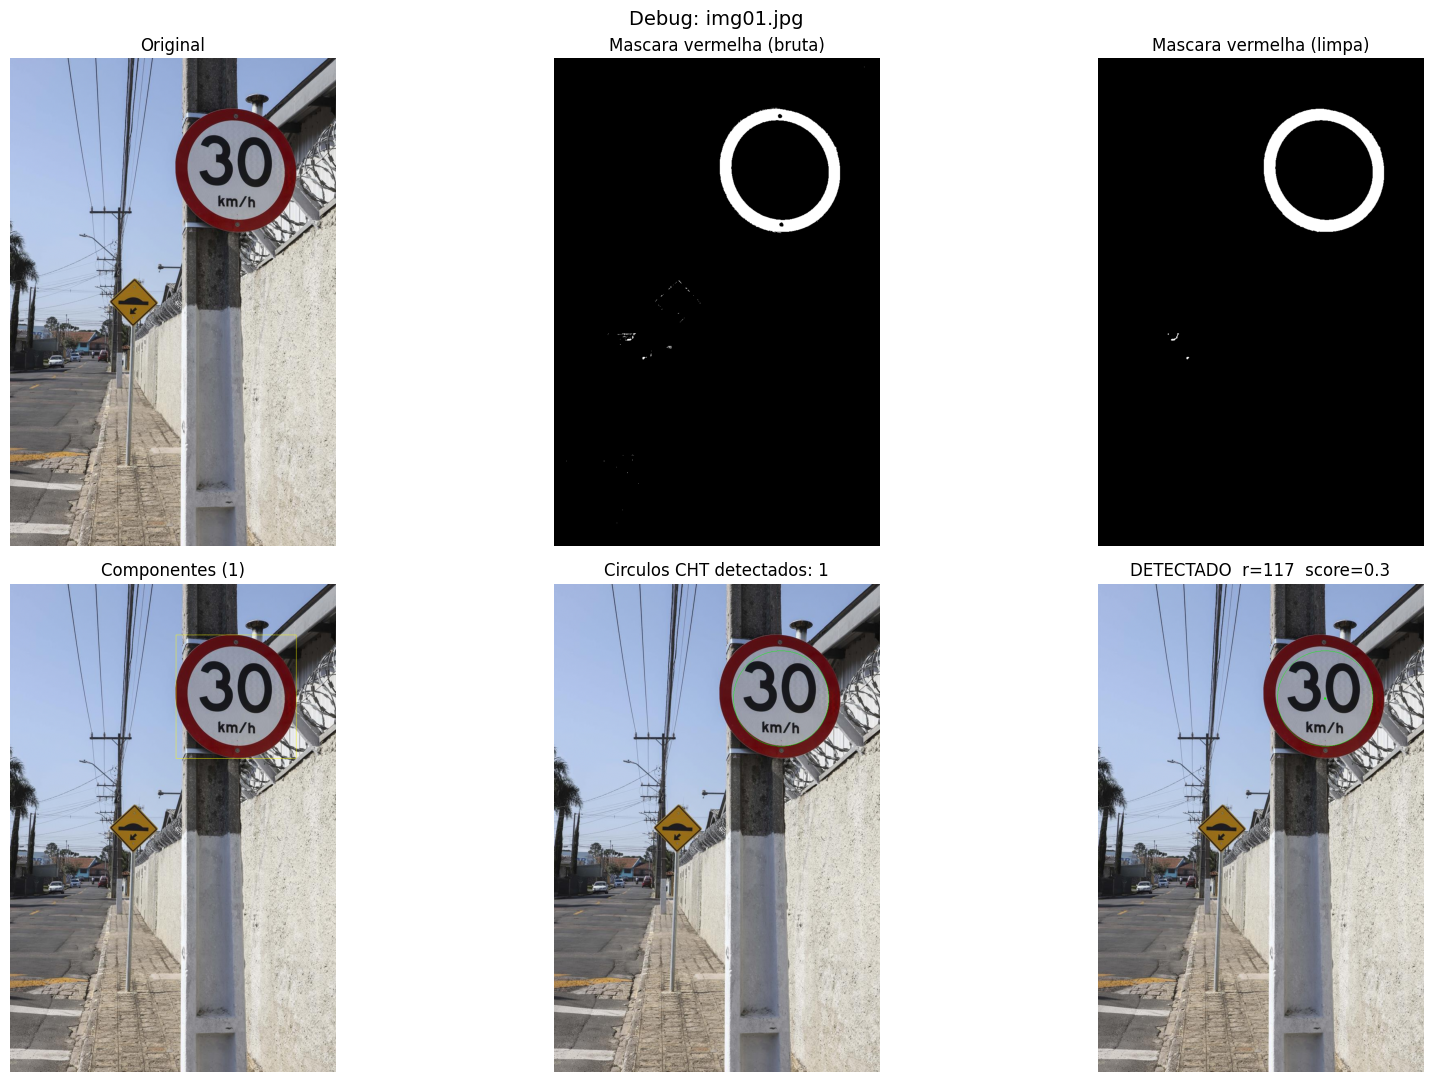

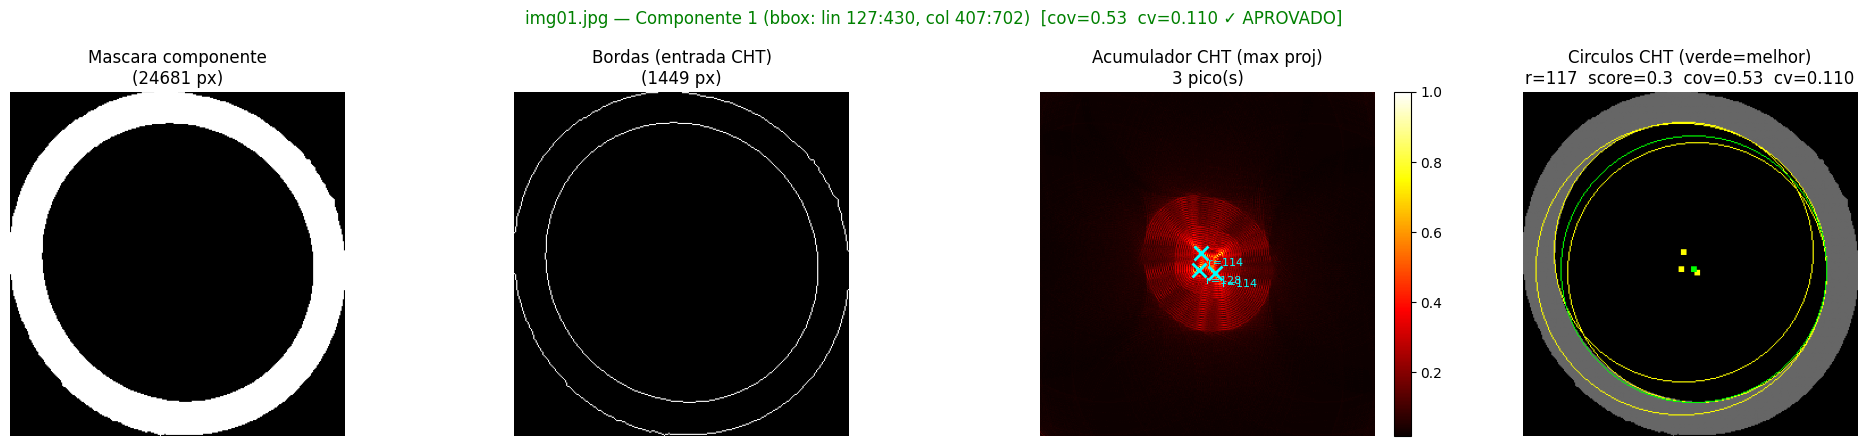

Tempo de execucao: 2325.99 ms


In [68]:
# Executar o pipeline na primeira imagem como teste rapido
if not caminhos_imagens:
    print("Nenhuma imagem para rodar o pipeline.")
else:
    resultado_exemplo = executar_pipeline_imagem(caminhos_imagens[0])
    exibir_debug_imagem(resultado_exemplo)
    exibir_debug_cht_componentes(resultado_exemplo)

    print(f"Tempo de execucao: {resultado_exemplo['execution_ms']:.2f} ms")

### 2.3) Processamento em lote — todas as imagens

A celula abaixo executa o pipeline em **todas as imagens** encontradas no diretorio `data/`. Para cada imagem:

1. Executa o pipeline completo (`executar_pipeline_imagem`).
2. Exibe o **painel de debug geral** com 6 subplots (visao geral do pipeline).
3. Exibe o **painel de debug da CHT** por componente (bordas, acumulador, circulos detectados).
4. Salva uma **figura resumo** (original + mascara + resultado) em `results/debug_images/`.

Ao final, imprime o total de imagens processadas e o caminho onde os debugs foram salvos.

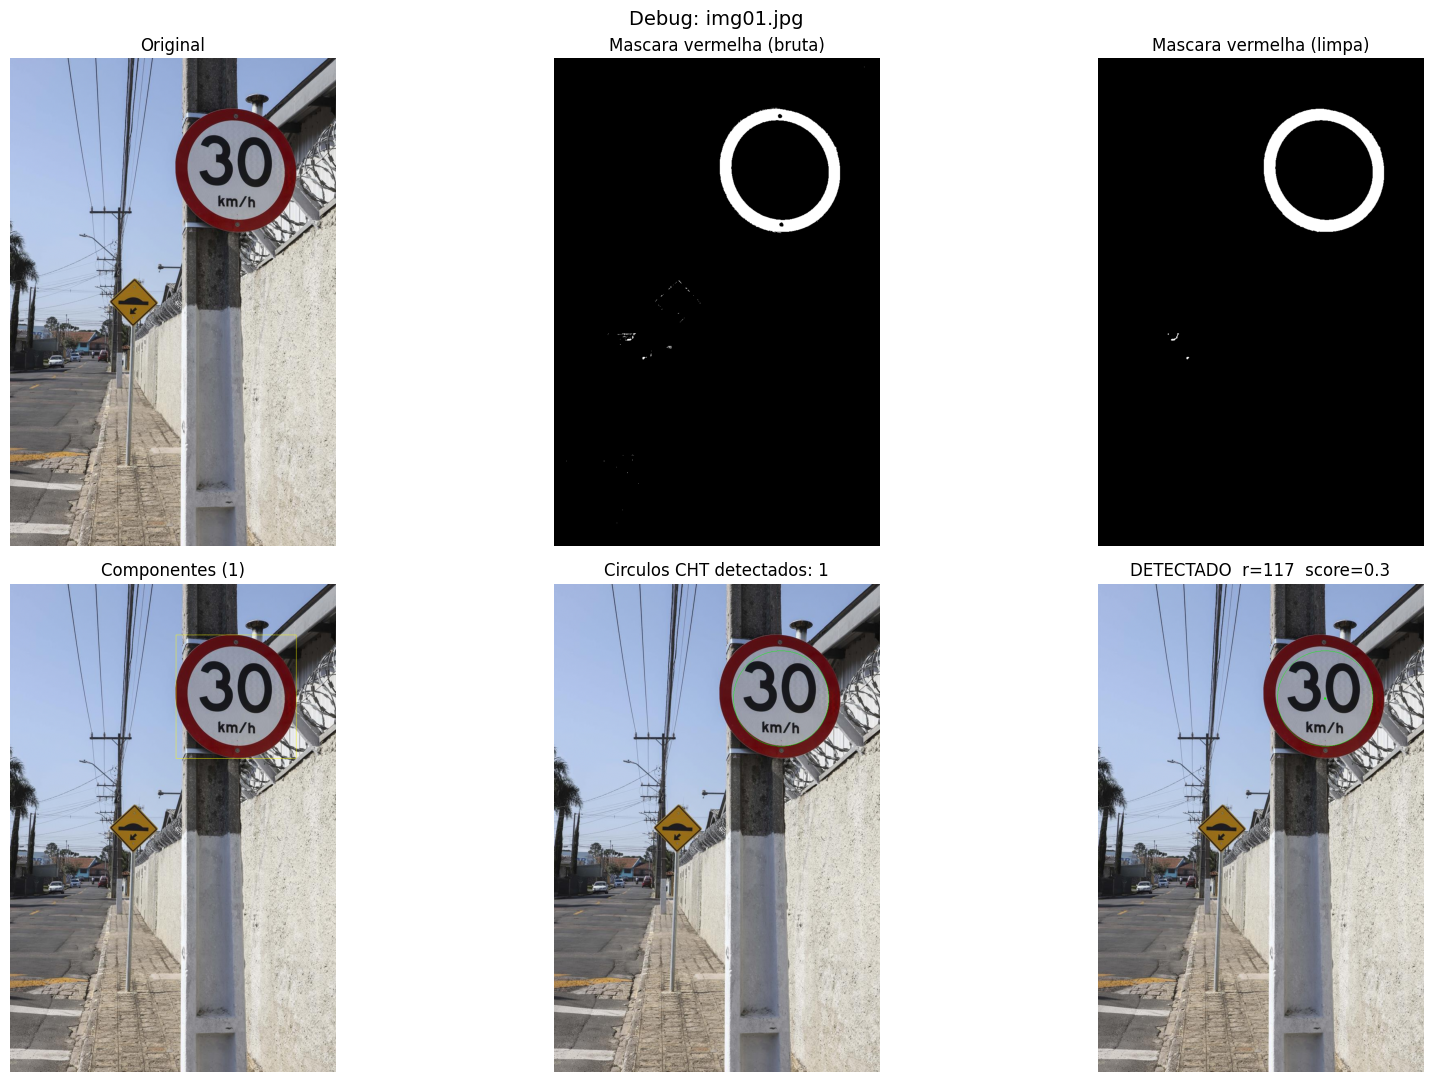

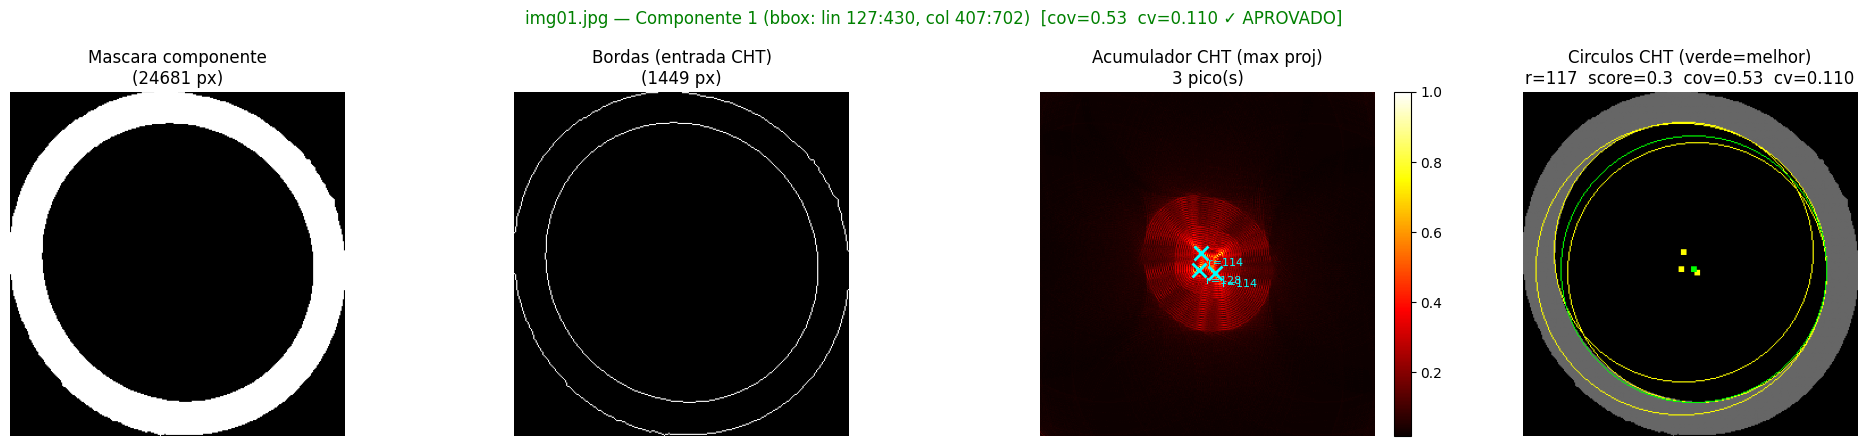

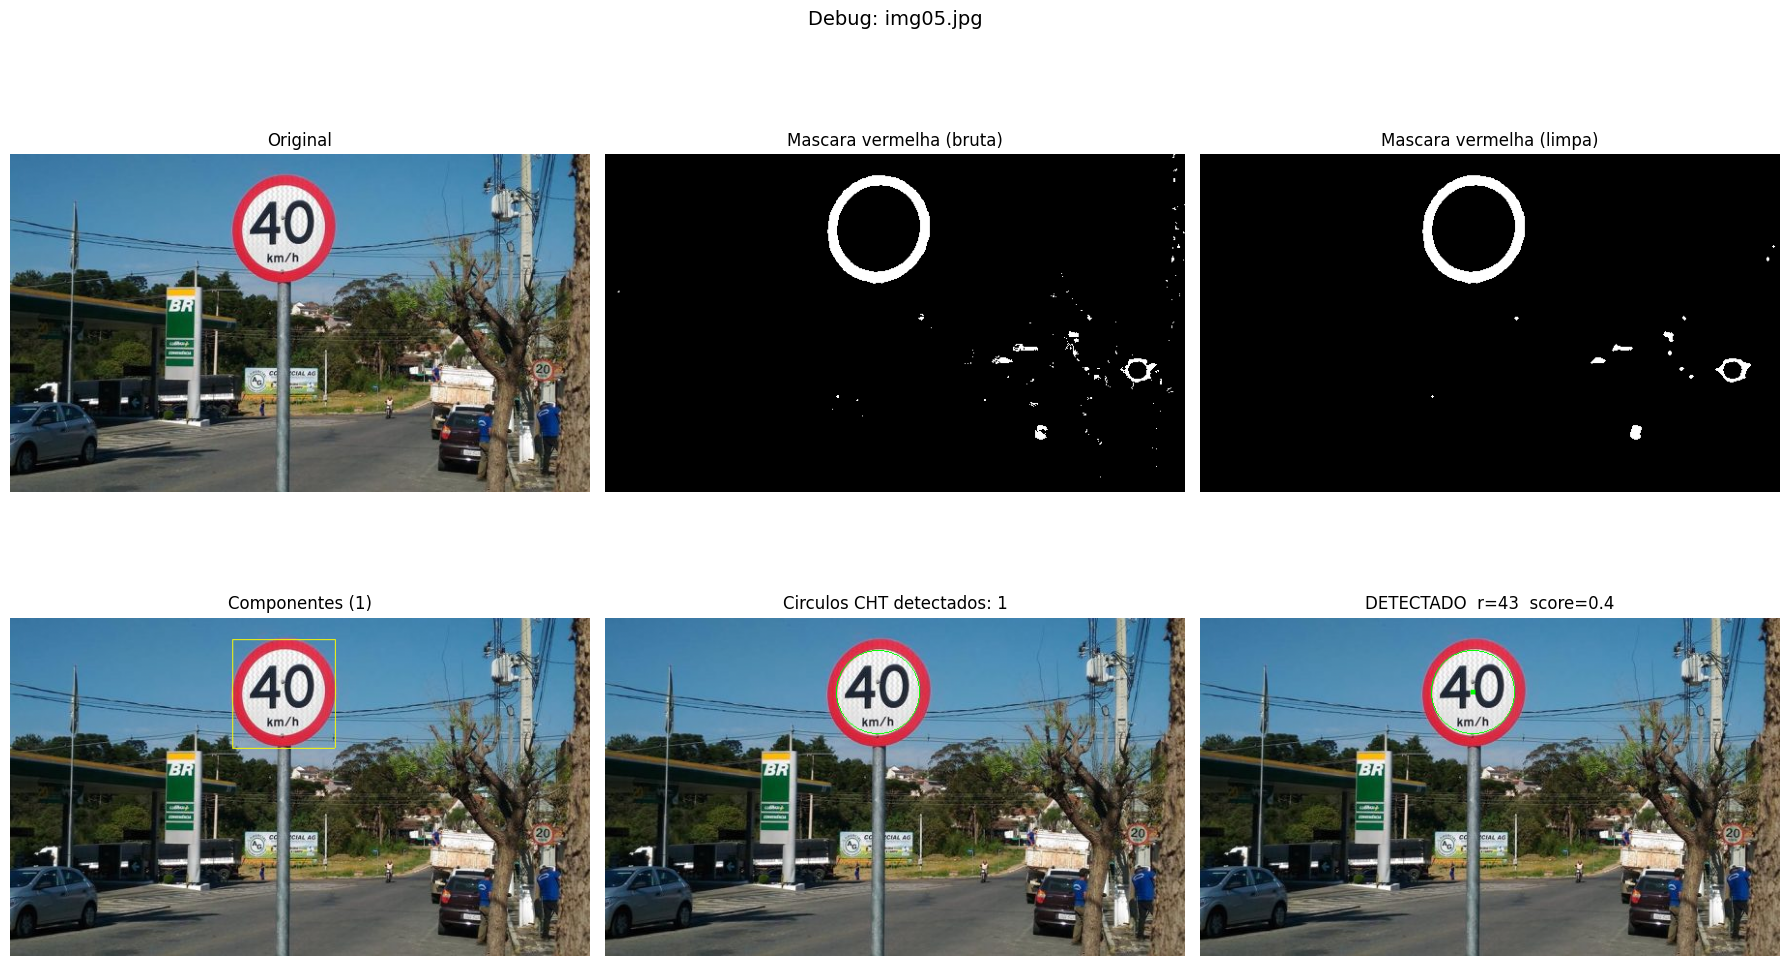

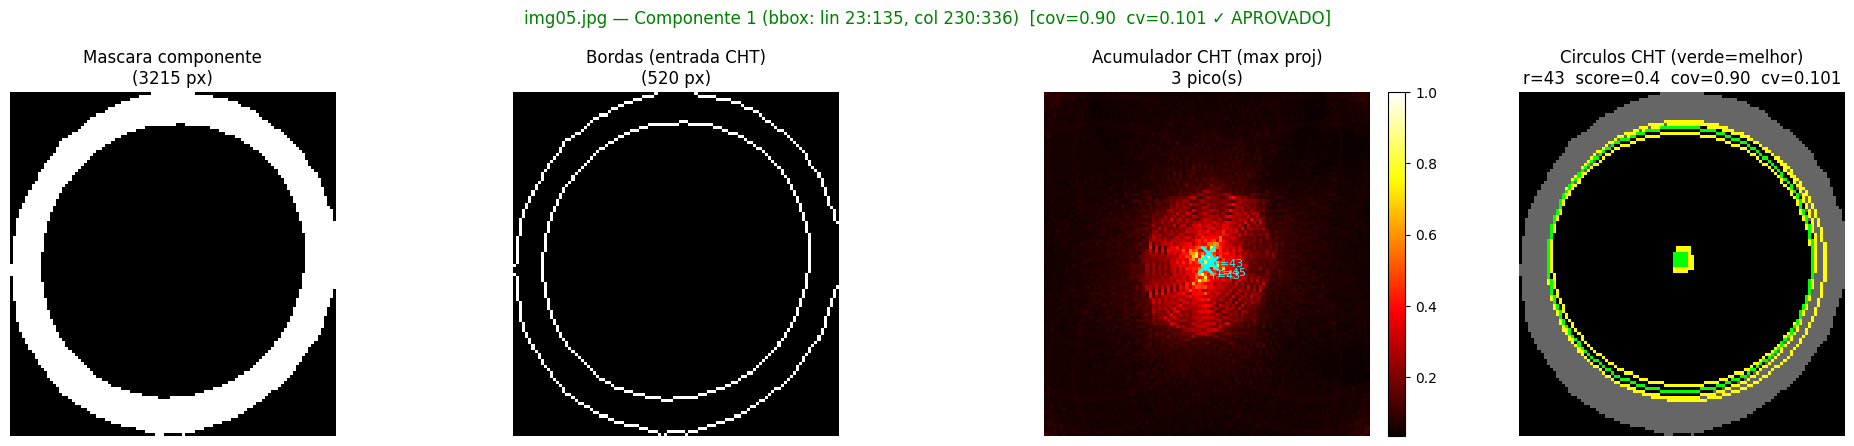

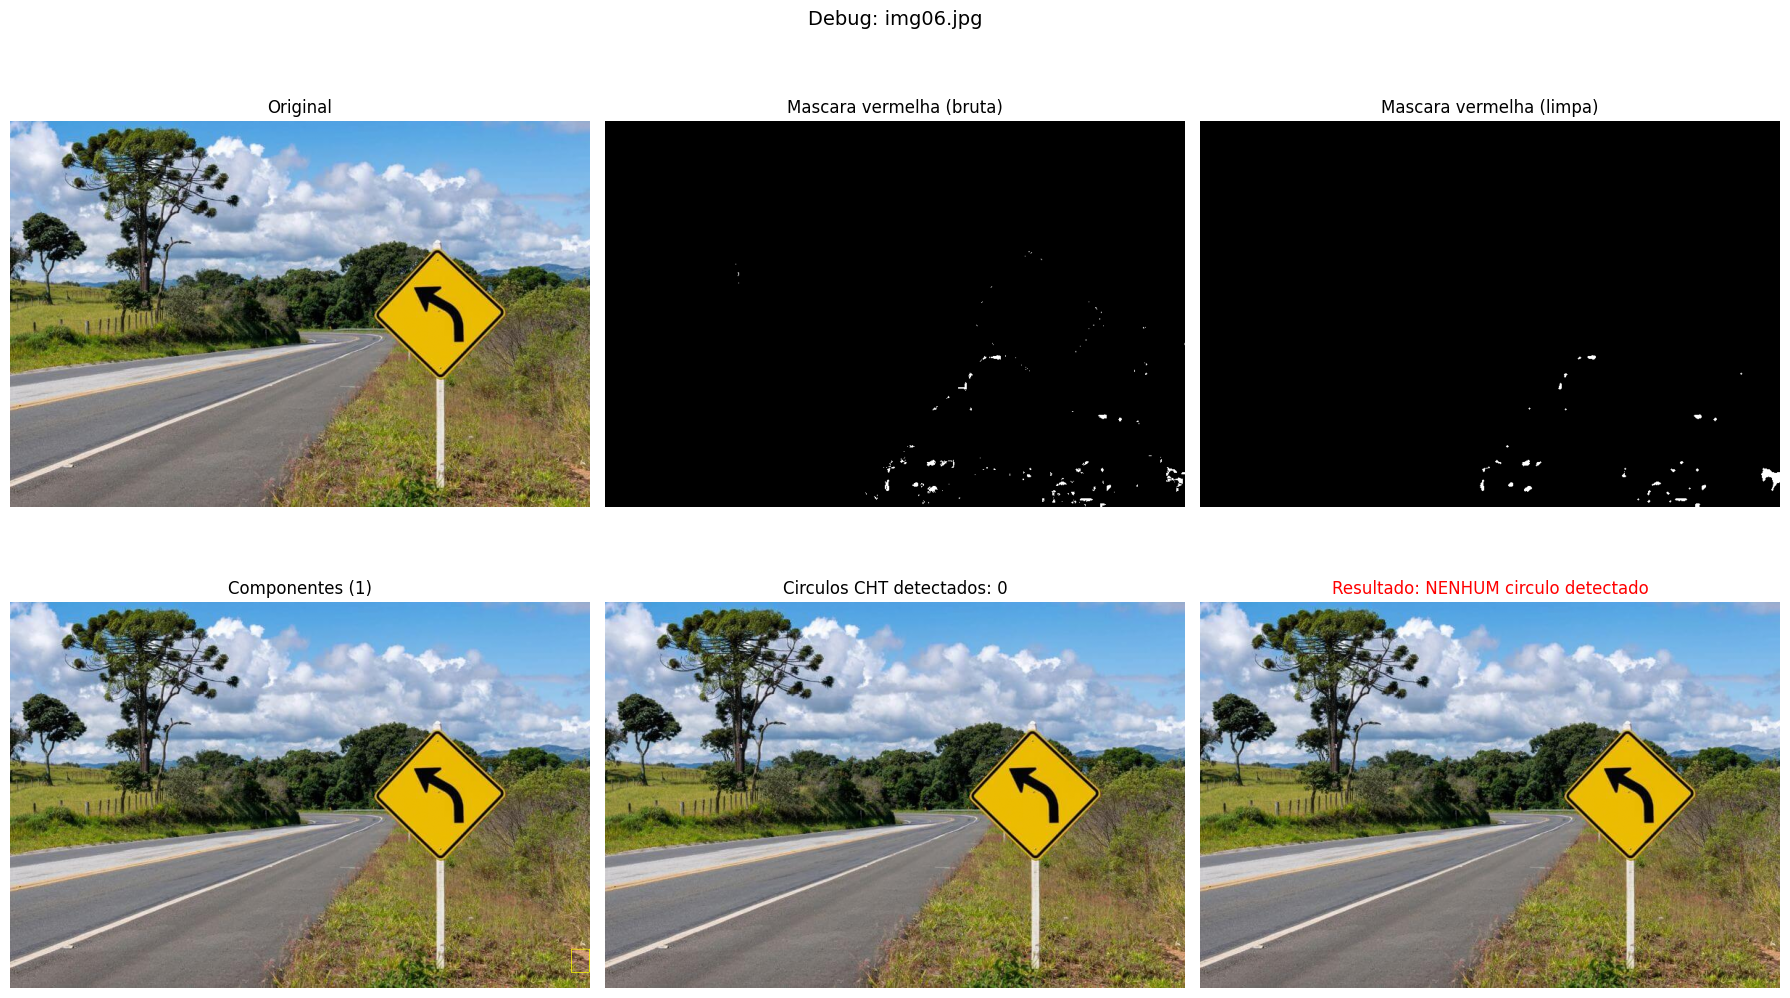

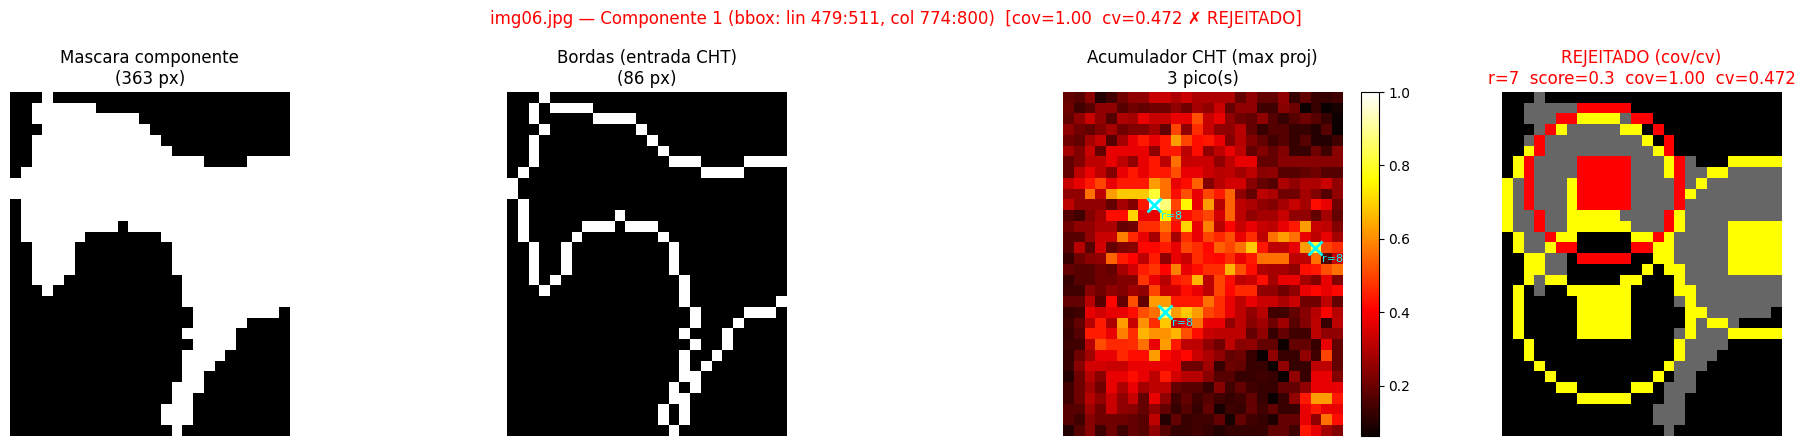

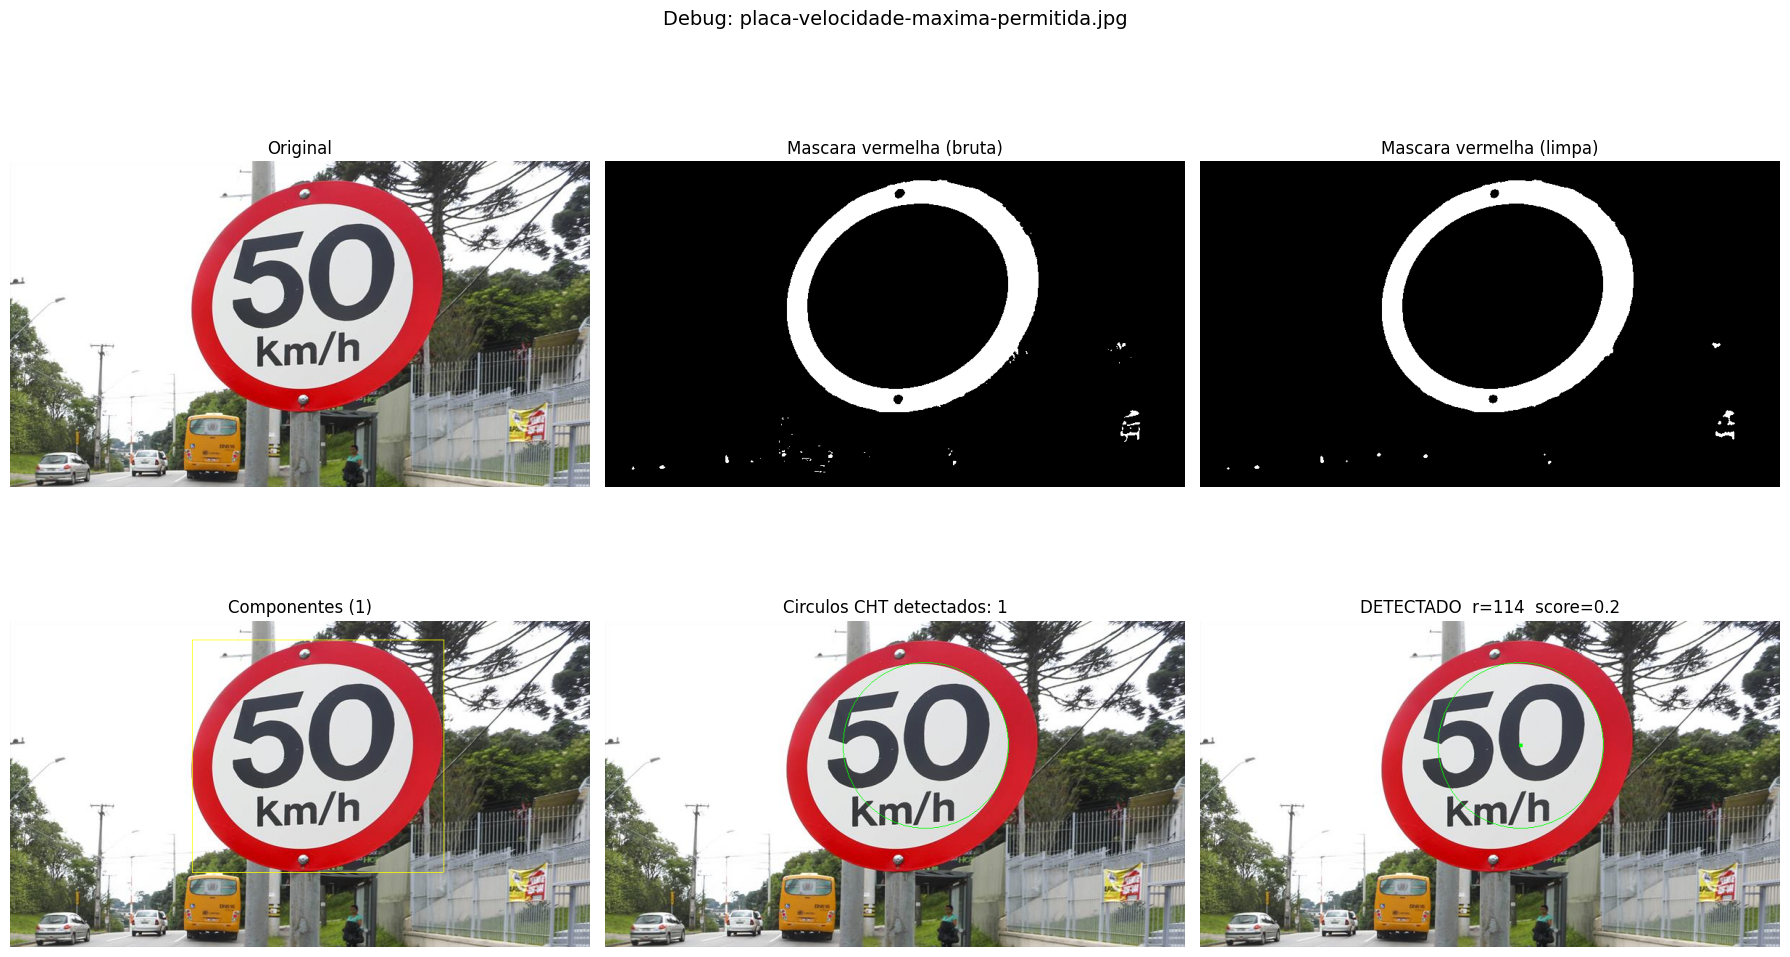

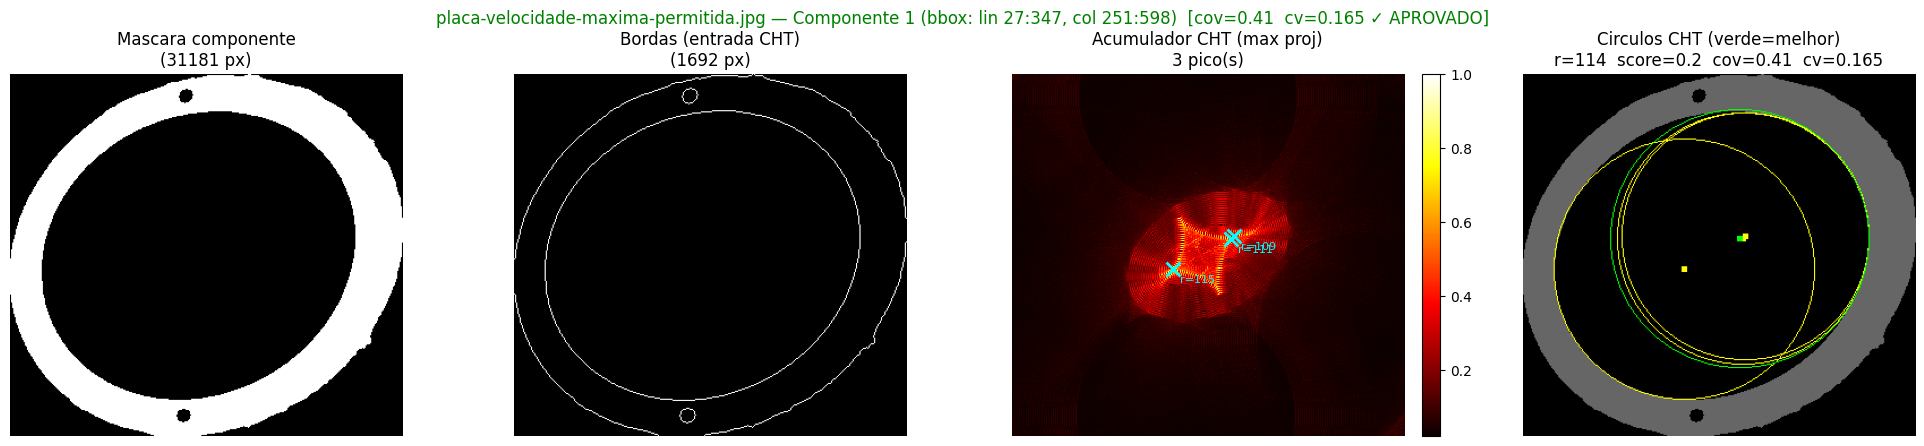

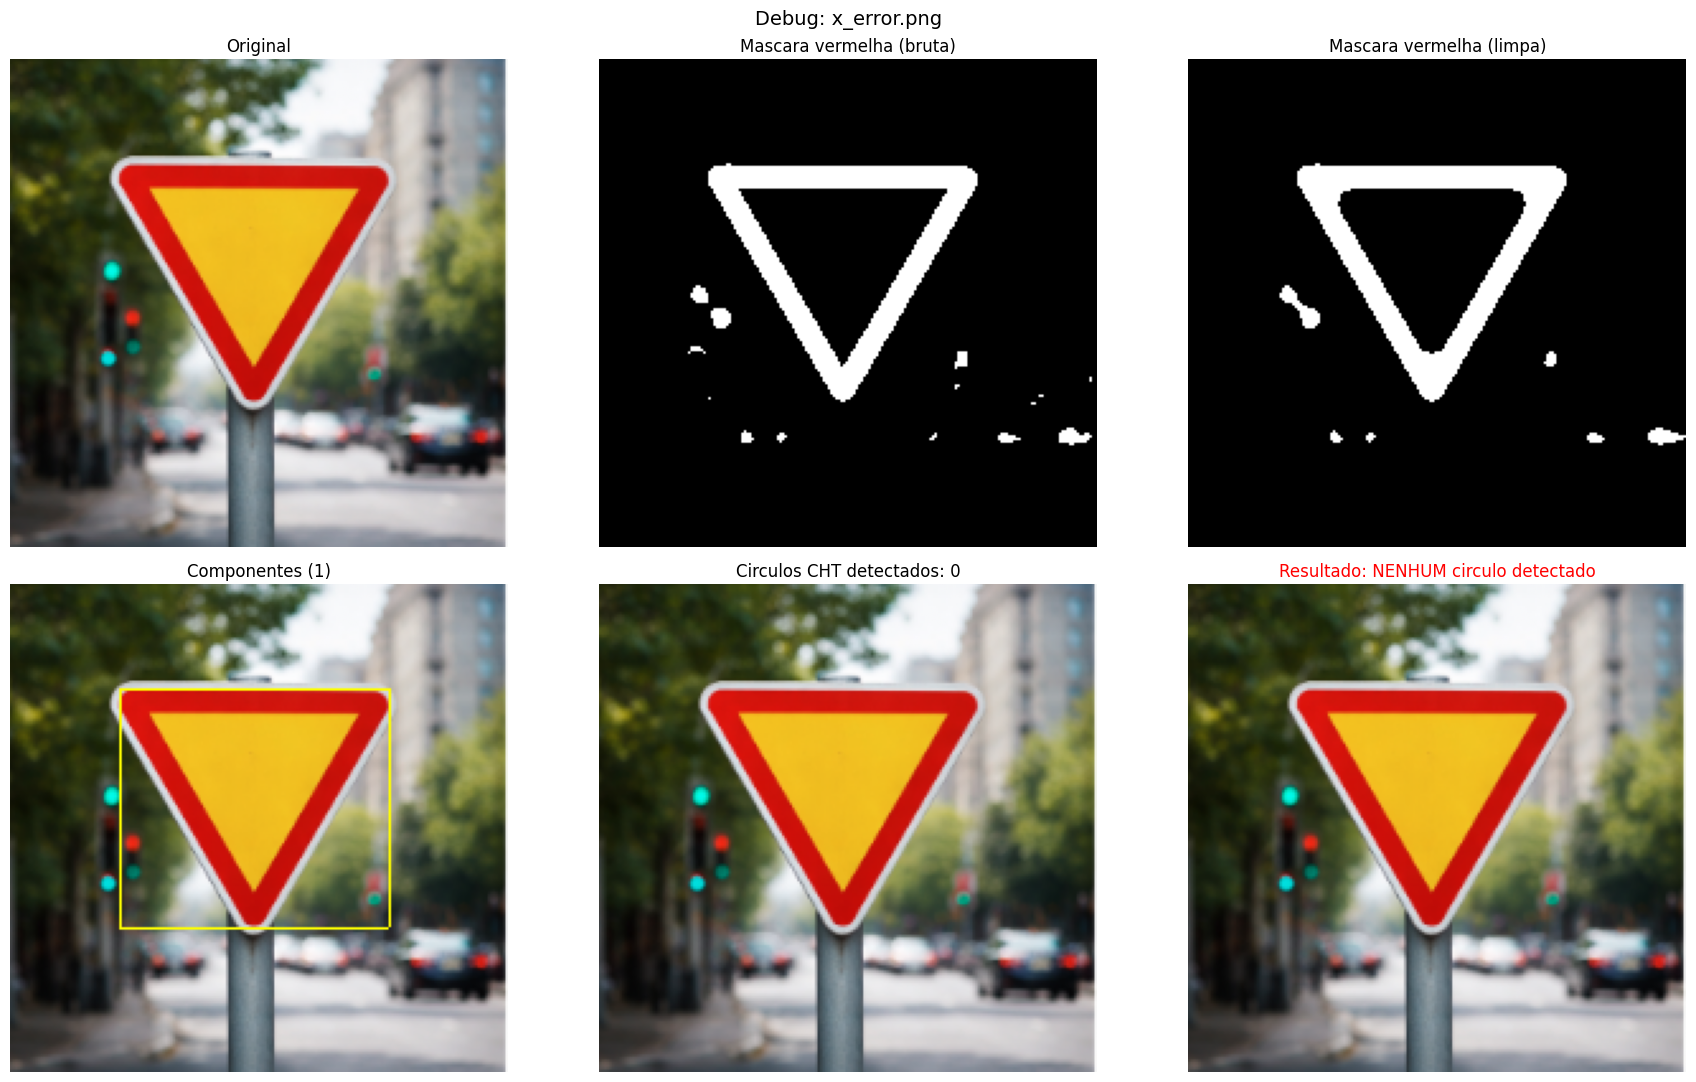

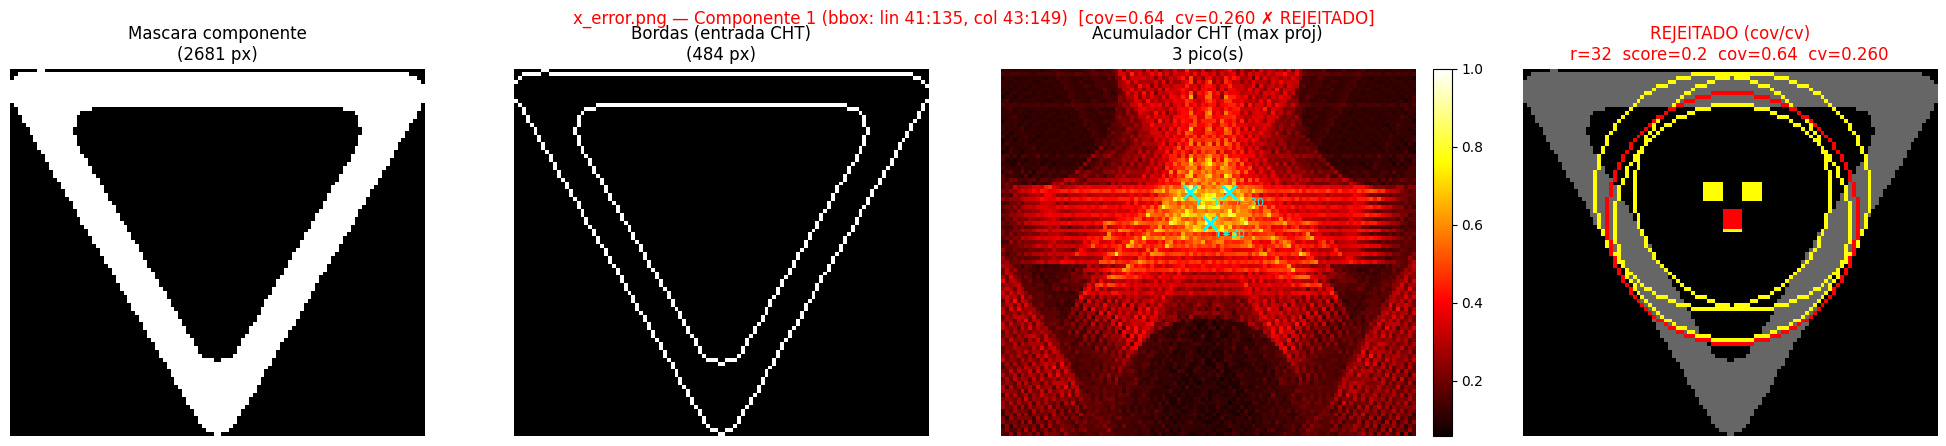


Debug salvo em: /home/givaldo/pi-trabalho-final-placas-circulares/results/debug_images
Total processadas: 5


In [69]:
# Executar o pipeline em TODAS as imagens e salvar figuras de debug
registros_pipeline = []

if not caminhos_imagens:
    print("Nenhuma imagem encontrada. Coloque imagens em data/ para executar o lote.")
else:
    for indice_imagem, caminho_imagem in enumerate(caminhos_imagens, start=1):
        resultado = executar_pipeline_imagem(caminho_imagem)
        dados_debug = resultado["debug"]
        melhor_circulo = resultado["best_circle"]

        registros_pipeline.append(
            {
                "image_path": resultado["image_path"],
                "n_components": resultado["n_components"],
                "n_circles_raw": resultado["n_circles_raw"],
                "best_circle_score": resultado["best_circle_score"],
                "execution_ms": resultado["execution_ms"],
                "detected": resultado["detected"],
            }
        )

        # ---------- Debug visual geral (6 subplots do pipeline) ----------
        exibir_debug_imagem(resultado)

        # ---------- Debug detalhado da CHT por componente ----------
        exibir_debug_cht_componentes(resultado)

        # ---------- Salvar figura resumo em disco ----------
        figura_salvar, eixos_salvar = plt.subplots(1, 3, figsize=(17, 5))

        eixos_salvar[0].imshow(dados_debug["original"])
        eixos_salvar[0].set_title("Original")
        eixos_salvar[0].axis("off")

        eixos_salvar[1].imshow(dados_debug["mask_clean"], cmap="gray")
        eixos_salvar[1].set_title("Mascara vermelha")
        eixos_salvar[1].axis("off")

        eixos_salvar[2].imshow(dados_debug["debug_overlay"])
        if melhor_circulo is None:
            eixos_salvar[2].set_title("Sem circulo detectado")
        else:
            eixos_salvar[2].set_title(
                f"r={melhor_circulo['radius']}  "
                f"score={melhor_circulo['score']:.1f}"
            )
        eixos_salvar[2].axis("off")

        figura_salvar.suptitle(caminho_imagem.name, fontsize=12)
        caminho_debug_salvar = DEBUG_DIR / f"{indice_imagem:03d}_{caminho_imagem.stem}_debug.png"
        figura_salvar.savefig(caminho_debug_salvar, dpi=140, bbox_inches="tight")
        plt.close(figura_salvar)

    print(f"\nDebug salvo em: {DEBUG_DIR.resolve()}")
    print(f"Total processadas: {len(caminhos_imagens)}")

**Observacoes sobre o pipeline**

O pipeline segue a seguinte logica para cada imagem:

1. **Segmentacao HSV** — isola pixels vermelhos usando limiarizacao multivariavel (Hue + Saturacao + Valor).
2. **Morfologia** — abertura remove ruido, fechamento preenche lacunas.
3. **Componentes conectados** — separa regioes isoladas e filtra por area (absoluta e relativa).
4. **CHT por componente** — aplica a Transformada Circular de Hough em cada componente individualmente, com faixa de raios adaptativa ao tamanho do componente.
5. **Selecao por score** — o circulo com maior score (mais votos no acumulador) e selecionado como resultado.

**Legenda do debug visual:**
- **Verde** = melhor circulo detectado (maior score da CHT)
- **Amarelo** = demais circulos candidatos

## Conclusao

- A segmentacao por cor no espaco HSV combinada com morfologia e componentes conectados permite isolar bem as regioes candidatas a placas vermelhas.
- A CHT aplicada por componente (com faixa de raios adaptativa) detecta circulos mesmo em cenas complexas.
- Componentes que nao correspondem a placas circulares podem gerar falsos positivos, pois a CHT sempre retorna circulos — nesses casos, a selecao de componentes por area ja filtra boa parte do ruido.

Entregas geradas por este notebook:
- `results/debug_images/`